<a href="https://colab.research.google.com/github/kojiyam/denso/blob/master/denso08_SIR_distribution_in_Poisson_cellular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. セルラネットワーク・ダウンリンク・評価尺度SIR・単一のシミュレーション

In [1]:
# 一般的なライブラリ・モジュール
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 16

In [2]:
# 擬似乱数のseed．研究では，再現性のため，擬似乱数のseedは固定すべき
np.random.seed(seed=1)

In [3]:
# パラメータ
BS_n = 40 # 基地局 (base station) の数
LENGTH = 1000 # システムエリアは，LENGTH (m) x LENGTH (m) の正方形とする．なお，原点を中心とする
ALPHA = 4. # pathloss exponent

In [4]:
# 乱数生成
# numpy.random.rand(d) 一様分布[0,1)に従う乱数d個
# numpy.random.exponential(scale=1.0, size=None) スケールパラメータscaleの指数分布に従う乱数size個
BS_x = np.random.rand(BS_n)*LENGTH-LENGTH/2 # BSのx座標
BS_y = np.random.rand(BS_n)*LENGTH-LENGTH/2 # BSのy座標
BS_h = np.random.exponential(scale=1.,size=BS_n) # BSと原点とのフェージング利得
BS_sorted_index = np.argsort(BS_x**2+BS_y**2) # 原点からの距離の順でソートした際の元のインデックス
# BS_sorted_index[0]が原点（ユーザ）から最近傍基地局．今回は所望局
# BS_sorted_index[1:BS_n]が干渉局

$ \Phi_{\mathrm{b}} = \{(\text{BS_x},\text{BS_y})\} = \{ x_0, x_1, \dots\}$

$ \displaystyle b_o = \arg\min_{ x \in \Phi_\mathrm{b}} \lVert x - o \rVert$

$ b_o = $ ( BS_x[BS_sorted_index[0]], BS_y[BS_sorted_index[0]] )

$ \Phi_{\mathrm{b}} \setminus b_o = $ { ( BS_x[BS_sorted_index[1:BS_n]], BS_y[BS_sorted_index[1:BS_n]] ) }

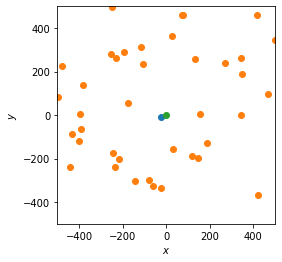

In [22]:
# 基地局の位置
plt.axes().set_aspect('equal',adjustable='box')
plt.xlim(-LENGTH/2,LENGTH/2)
plt.ylim(-LENGTH/2,LENGTH/2)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.scatter(BS_x[BS_sorted_index[0]],BS_y[BS_sorted_index[0]]) # 所望局
plt.scatter(BS_x[BS_sorted_index[1:BS_n]],BS_y[BS_sorted_index[1:BS_n]]) # 干渉局
plt.scatter(0,0) # 原点．ユーザ

 $ S = h_{b_o} \lVert b_o \rVert^{-\alpha} $

 $ \displaystyle I = \sum_{ x \in \Phi_\mathrm{b} \setminus b_o } h_x \lVert x \rVert^{-\alpha} $

In [6]:
# 所望信号電力

S = BS_h[BS_sorted_index[0]] * (BS_x[BS_sorted_index[0]]**2+BS_y[BS_sorted_index[0]]**2)**(-ALPHA/2) # 所望信号電力

# 干渉電力
I = np.sum( BS_h[BS_sorted_index[1:BS_n]] * (BS_x[BS_sorted_index[1:BS_n]]**2+BS_y[BS_sorted_index[1:BS_n]]**2)**(-ALPHA/2) ) # 干渉電力

print (S/I)

4.082209885227988


# 2. モンテカルロシミュレーション

In [7]:
LOOP_n = 1000 # 値を変えてecdfを描いてみるとよい
#isPPP = False
isPPP = True # こちらにすると，BSをシステムエリア内に平均BS_n局のPPPにする

In [8]:
SIR_list = list()
for i in range (LOOP_n):
  if isPPP == True:
    BS_np = np.random.poisson(BS_n)
  else:
    BS_np = BS_n
  
  # 以下，単一の場合と同じ
  BS_x = np.random.rand(BS_np)*LENGTH-LENGTH/2
  BS_y = np.random.rand(BS_np)*LENGTH-LENGTH/2
  BS_h = np.random.exponential(1,BS_np)
  BS_sorted_index = np.argsort(BS_x**2+BS_y**2)
  S = (BS_x[BS_sorted_index[0]]**2+BS_y[BS_sorted_index[0]]**2)**(-ALPHA/2) * BS_h[BS_sorted_index[0]]
  I = np.sum(BS_h[BS_sorted_index[1:BS_np]] * (BS_x[BS_sorted_index[1:BS_np]]**2+BS_y[BS_sorted_index[1:BS_np]]**2)**(-ALPHA/2))
  # 以上，単一の場合と同じ

  # dB値で保存
  SIR_list.append(10*np.log10(S/I))

  # 繰り返し数が多い場合に，経過表示
  if (i%1000==0):
    print(i)

0


In [9]:
# ecdfを描くためにソート
SIR_list.sort()

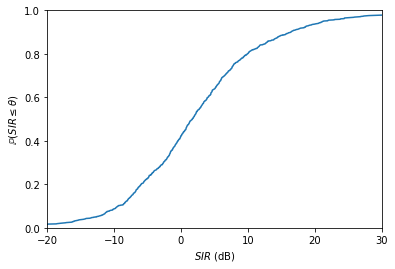

In [20]:
# ecdfを描く
plt.xlim(-20,30)
plt.ylim(0,1)
plt.xlabel(r"$\mathit{SIR}$ (dB)")
plt.ylabel(r"$\mathbb{P}(\mathit{SIR} \leq \theta)$")
plt.plot(SIR_list,np.array(range(LOOP_n))/LOOP_n)

# 3. 確率幾何解析

$ \displaystyle \mathbb{P} ( \mathit{SIR} \leq \theta) = 1- \frac{1}{1+\sqrt{\theta} \arctan \sqrt{\theta}} $

この式の導出を，確率幾何を知らない無線の専門家に教えようとすると，せめて1時間ほしい

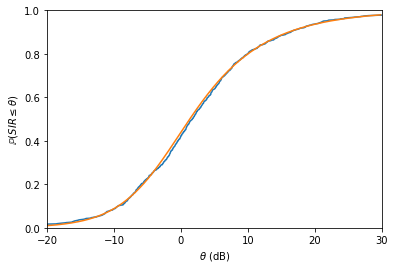

In [17]:
x = np.arange(-20,30,0.2)
x_lin = 10**(x/10)
y = 1-1/(1+np.sqrt(x_lin)*np.arctan(np.sqrt(x_lin))) # これが確率幾何解析の結果．他は上と同じ

plt.xlim(-20,30)
plt.ylim(0,1)
plt.xlabel(r"$\theta$ (dB)")
plt.ylabel(r"$\mathbb{P}(\mathit{SIR} \leq \theta)$")
plt.plot(SIR_list,np.array(range(LOOP_n))/LOOP_n)
plt.plot(x,y)